# Challenge: Boston marathon

You now have a pretty varied suite of clustering and clustering evaluation methods; we'd be remiss if we didn't give you the opportunity to try them out on some real data. So here we go!

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

In [45]:
# Utilities
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
%matplotlib inline

#Processing tools
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

#Models
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

In [22]:
results_raw = pd.read_csv('https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv')
pd.options.display.max_columns = 50

## Data exploration and preparation 

In [23]:
results_raw.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.40,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [24]:
results_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


In [25]:
results_raw.nunique()

10k           2766
name         31915
division      6979
25k           6570
gender           2
age             64
official     11030
bib          31984
genderdiv    17575
ctz             84
35k           9516
overall      31931
pace           727
state           68
30k           8090
5k            1491
half          5651
20k           5375
country         78
city          5934
40k          10546
dtype: int64

Some of the categorical variables have too many unique values so we'll drop them. Name and bib clums are unique to each athelet and have no information. We'll make a copy of the data frame first and drop unwanted columns. Gender can be converted to binary. 

In [26]:
# Make a copy
results = results_raw.copy()
# Drop unwanted
results = results_raw.drop(['name','bib','ctz','state','country','city'], axis=1)

In [34]:
# make gender binary using boolians 
results['gender'] = results['gender'].apply(lambda x: 0 if x is 'M' else 1)

In [35]:
# Confirm change
results.tail()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
31979,50.72,3414,124.02,0,32,211.75,7500,174.90,9849,8.08,148.65,26.13,104.78,99.55,200.22
31980,61.28,5212,165.02,0,34,302.52,15459,244.70,27456,11.55,203.43,31.07,135.85,128.37,285.47
31981,59.00,5231,157.02,1,21,282.00,10788,229.62,25092,10.77,192.65,28.18,130.57,123.33,266.30
31982,63.75,5800,167.82,1,38,302.73,12009,247.18,27476,11.55,207.52,30.98,137.03,129.90,285.87
31983,53.63,1396,135.02,0,54,228.30,9771,189.68,14844,8.72,161.83,26.92,114.13,108.03,216.48


5k, 10k,...etc are time stamps for those kilometer marks so we'll change them to numeric data types. Inspecting the entries shows that some of those columns have a '-' value. we'll replace them with the average of the column. 

In [36]:
marks = ['5k', '10k', 'half', '20k', '25k', '30k', '35k', '40k']

for mark in marks:
    results[mark] = pd.to_numeric(results[mark], errors='coerce')
    results[mark] = results[mark].map(lambda x: results[mark].mean() if x is '-' else float(x))

# Confirm changes
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 15 columns):
10k          31934 non-null float64
division     31984 non-null int64
25k          31768 non-null float64
gender       31984 non-null int64
age          31984 non-null int64
official     31984 non-null float64
genderdiv    31984 non-null int64
35k          31950 non-null float64
overall      31984 non-null int64
pace         31984 non-null float64
30k          31944 non-null float64
5k           31932 non-null float64
half         31912 non-null float64
20k          31933 non-null float64
40k          31945 non-null float64
dtypes: float64(10), int64(5)
memory usage: 3.7 MB


In [37]:
# Check for missing values 
results.isnull().sum()

10k           50
division       0
25k          216
gender         0
age            0
official       0
genderdiv      0
35k           34
overall        0
pace           0
30k           40
5k            52
half          72
20k           51
40k           39
dtype: int64

Converting data types to numeric has created some missing values. We'll replace them with the column mean

In [41]:
# Replace missing with mean value
for mark in marks:
    results[mark].fillna(results[mark].mean(), inplace=True)

# Confirm change
results.isnull().sum()

10k          0
division     0
25k          0
gender       0
age          0
official     0
genderdiv    0
35k          0
overall      0
pace         0
30k          0
5k           0
half         0
20k          0
40k          0
dtype: int64

In [43]:
results.head()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
0,17.37,8,47.67,0,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43
1,32.58,1,82.43,1,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10
2,16.62,1,45.80,0,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10
3,32.57,3,82.43,1,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95
4,17.12,2,46.37,0,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72


## Modeling

In [46]:
# Let's call the data X for simplicity
X = results.copy()

In [47]:
# Normalize
X_norm = normalize(X)


# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)


In [49]:
#check the length of each set 
print('If length is the same, only True will print:',
      len(X1) == len(X_pca1),
      len(X2) == len(X_pca2),
      len(X3) == len(X_pca3),
      len(X4) == len(X_pca4))

If length is the same, only True will print: True True True True


### 1. K-means

In [50]:
#set df to store predictions and score
ypred = pd.DataFrame()
sil_scores = pd.DataFrame(columns = ['cluster', 'sil_score'])

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    #cluster predictions for clusters 2 to 6.
    for nclust in range(2, 7):
        model = KMeans(n_clusters=nclust, random_state=42)
        pred = model.fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
        
        #silhouette scores
        labels = model.labels_
        sil_score = metrics.silhouette_score(data[0],
                                             labels,
                                             metric='euclidean')
        sil_scores = sil_scores.append({
            'cluster':'clust' + str(nclust) + '_sample' + str(counter), 
            'sil_score':sil_score},
            ignore_index=True)

In [51]:
sil_scores.sort_values(by='sil_score', ascending=False)

,cluster,sil_score
7,clust4_sample1,0.495658
2,clust4_sample0,0.493525
12,clust4_sample2,0.493257
17,clust4_sample3,0.491322
6,clust3_sample1,0.478796
16,clust3_sample3,0.476207
11,clust3_sample2,0.476144
1,clust3_sample0,0.474392
0,clust2_sample0,0.459806
8,clust5_sample1,0.457907


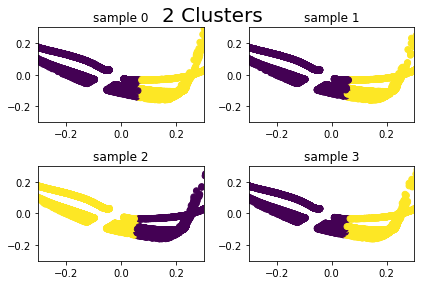

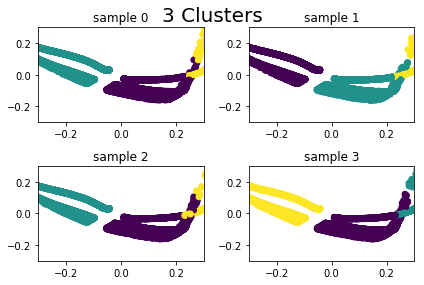

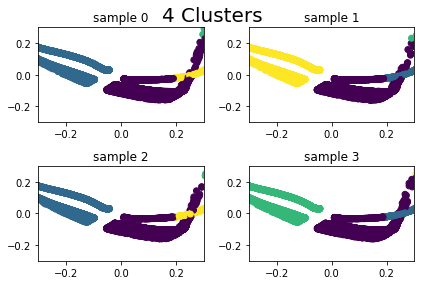

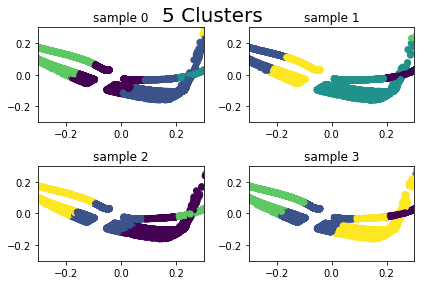

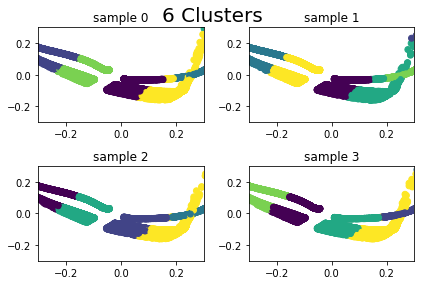

In [52]:
#plot solutions
for cluster in range(2, 7):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')


### 2. Mean Shift

In [53]:
ypred = pd.DataFrame()
sil_scores = pd.DataFrame(columns = ['cluster', 'sil_score', 'quantile'])

for counter, data in enumerate([X1, X2, X3, X4]):
    
    #iterate through possible quantiles for cluster solutions
    for quantile in [0.1, 0.2, 0.3, 0.4, 0.5]:
        bandwidth = estimate_bandwidth(data, quantile=quantile, n_samples=500)
        model = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = model.fit_predict(data)
        labels = model.labels_
        nclust = len(np.unique(labels))
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
        sil_score = metrics.silhouette_score(data, labels, metric='euclidean')
        sil_scores = sil_scores.append({
            'cluster':'clust' + str(nclust) + '_sample' + str(counter), 
            'sil_score':sil_score,
            'quantile':quantile},
            ignore_index=True)

In [54]:
sil_scores.sort_values(by='sil_score', ascending=False)

,cluster,sil_score,quantile
9,clust2_sample1,0.738678,0.5
14,clust4_sample2,0.570846,0.5
1,clust4_sample0,0.530170,0.2
6,clust4_sample1,0.525162,0.2
11,clust4_sample2,0.518161,0.2
2,clust4_sample0,0.515556,0.3
8,clust4_sample1,0.513436,0.4
3,clust4_sample0,0.505169,0.4
17,clust5_sample3,0.500969,0.3
4,clust3_sample0,0.499935,0.5


### 3. Spectral Clustering

In [55]:
#set df for predictions
ypred = pd.DataFrame()
sil_scores = pd.DataFrame(columns = ['cluster', 'sil_score'])

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    #cluster predictions for clusters 2 to 6.
    for nclust in range(2, 7):
        model = SpectralClustering(n_clusters=nclust)
        pred = model.fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
        #silhouette scores
        labels = model.labels_
        sil_score = metrics.silhouette_score(data[0],
                                             labels,
                                             metric='euclidean')
        sil_scores = sil_scores.append({
            'cluster':'clust' + str(nclust) + '_sample' + str(counter), 
            'sil_score':sil_score},
            ignore_index=True)

In [56]:
sil_scores.sort_values(by='sil_score', ascending=False)

,cluster,sil_score
7,clust4_sample1,0.492952
2,clust4_sample0,0.492336
12,clust4_sample2,0.490365
17,clust4_sample3,0.488481
6,clust3_sample1,0.476786
16,clust3_sample3,0.474210
11,clust3_sample2,0.473528
1,clust3_sample0,0.471070
10,clust2_sample2,0.444203
5,clust2_sample1,0.442637


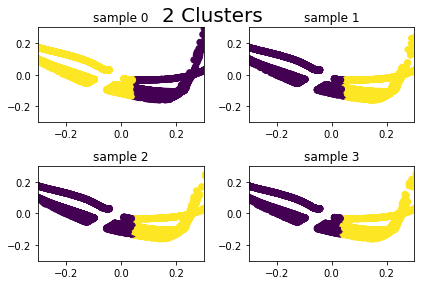

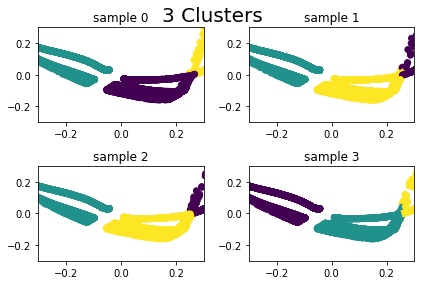

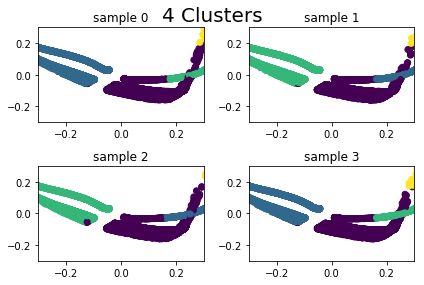

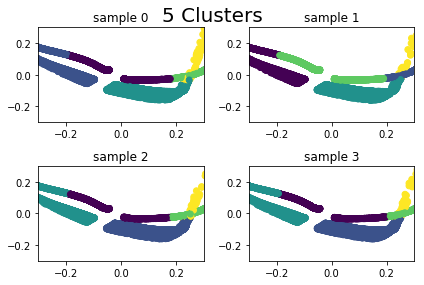

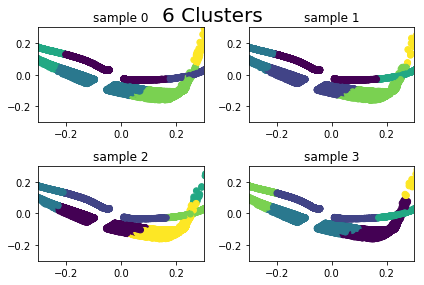

In [57]:
#plot solutions
for cluster in range(2, 7):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')


### 4. Affinity propagation

In [61]:
# Take a sample of data to reduce runtime
af_data = X.sample(frac=0.5)

af_norm = normalize(af_data)
af_pca = PCA(2).fit_transform(af_norm)

X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    af_norm,
    af_pca,
    test_size=0.5,
    random_state=42
    )
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

#make sure it worked
print('should all be True:',
      len(X1) == len(X_pca1),
      len(X2) == len(X_pca2),
      len(X3) == len(X_pca3),
      len(X4) == len(X_pca4))

should all be True: True True True True


In [62]:
ypred = pd.DataFrame()
sil_scores = pd.DataFrame(columns = ['cluster', 'sil_score'])

for counter, data in enumerate([X1, X2, X3, X4]):
    #fit model
    model = AffinityPropagation().fit(data)
    cluster_centers_indices = model.cluster_centers_indices_
    n_clusters = len(cluster_centers_indices)
    labels = model.labels_
    #silhouette scores
    sil_score = metrics.silhouette_score(data, labels, metric='euclidean')
    sil_scores = sil_scores.append({
        'cluster':'clust' + str(n_clusters) + '_sample' + str(counter), 
        'sil_score':sil_score},
        ignore_index=True)

In [63]:
sil_scores.sort_values(by='sil_score', ascending=False)

,cluster,sil_score
0,clust1777_sample0,0.202076
1,clust1478_sample1,0.196319
2,clust1654_sample2,0.140146
3,clust2464_sample3,0.119391


### Observations

Mean shift clustering produced the highest silhouette score but the scores are not consistent among samples. K-means clustering has the most consistent results as measured by silhouette score and therefore should be used for this dataset. 

Affinity propagation produces too many clusters with low silhouette score. It also takes the longest time to run. 

In [64]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(X_norm)

In [67]:
cluster = pd.DataFrame(y_pred)
cluster.columns = ['cluster']

In [96]:
# Add the outcome back onto X
results_clus = X.join(cluster, how='inner')


In [97]:
results_clus.tail()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,cluster
31979,50.72,3414,124.02,0,32,211.75,7500,174.90,9849,8.08,148.65,26.13,104.78,99.55,200.22,0
31980,61.28,5212,165.02,0,34,302.52,15459,244.70,27456,11.55,203.43,31.07,135.85,128.37,285.47,0
31981,59.00,5231,157.02,1,21,282.00,10788,229.62,25092,10.77,192.65,28.18,130.57,123.33,266.30,1
31982,63.75,5800,167.82,1,38,302.73,12009,247.18,27476,11.55,207.52,30.98,137.03,129.90,285.87,1
31983,53.63,1396,135.02,0,54,228.30,9771,189.68,14844,8.72,161.83,26.92,114.13,108.03,216.48,0


In [98]:
# Separate the clusters
cluster0 = results_clus[results_clus['cluster']==0]
cluster1 = results_clus[results_clus['cluster']==1]
cluster2 = results_clus[results_clus['cluster']==2]
cluster3 = results_clus[results_clus['cluster']==3]

In [99]:
cluster0.describe()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,cluster
count,14176.000000,14176.000000,14176.000000,14176.0,14176.000000,14176.000000,14176.000000,14176.000000,14176.000000,14176.000000,14176.000000,14176.000000,14176.000000,14176.000000,14176.000000,14176.0
mean,51.813095,1763.016930,133.782515,0.0,47.613361,246.298528,10249.660412,198.310099,16523.926213,9.401233,165.109543,25.782751,111.656106,105.669725,231.674454,0.0
std,8.448354,1549.443879,24.241838,0.0,10.451891,51.041348,4464.722869,40.566353,8998.524218,1.943504,32.460294,4.116021,19.839491,18.586721,47.747179,0.0
min,32.120000,1.000000,70.000000,0.0,18.000000,161.250000,356.000000,132.180000,383.000000,6.170000,109.230000,15.680000,68.730000,65.150000,152.350000,0.0
25%,45.300000,568.000000,115.550000,0.0,41.000000,207.930000,6856.500000,167.920000,8658.500000,7.930000,140.850000,22.580000,96.745000,91.645000,195.745000,0.0
50%,49.950000,1318.000000,128.120000,0.0,48.000000,234.350000,10487.500000,188.580000,16539.500000,8.950000,157.180000,24.880000,106.970000,101.320000,220.420000,0.0
75%,57.150000,2346.000000,147.650000,0.0,55.000000,277.480000,14031.250000,221.905000,24479.250000,10.585000,183.535000,28.530000,122.850000,116.270000,260.670000,0.0
max,112.380000,5911.000000,289.020000,0.0,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000,0.0


In [100]:
cluster1.describe()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,cluster
count,14325.000000,14325.000000,14325.000000,14325.0,14325.000000,14325.000000,14325.000000,14325.000000,14325.000000,14325.000000,14325.000000,14325.000000,14325.000000,14325.000000,14325.000000,14325.0
mean,54.585484,2177.806213,141.231194,1.0,39.818360,255.169306,7194.000000,207.799551,18514.934101,9.740075,174.091407,27.084700,118.059604,111.775175,240.889329,1.0
std,8.046740,1958.694205,23.288853,0.0,10.511916,48.078982,4135.415638,38.778740,7804.837265,1.831806,31.463444,3.820911,19.355247,18.183552,45.257580,0.0
min,37.350000,1.000000,93.980000,1.0,18.000000,163.450000,32.000000,135.000000,491.000000,6.250000,114.070000,18.480000,79.230000,75.170000,154.850000,1.0
25%,48.730000,626.000000,124.320000,1.0,31.000000,219.480000,3613.000000,179.530000,12280.000000,8.380000,151.320000,24.270000,104.150000,98.680000,207.380000,1.0
50%,52.770000,1485.000000,135.330000,1.0,40.000000,242.420000,7194.000000,197.250000,18567.000000,9.250000,165.720000,26.280000,113.180000,107.230000,228.730000,1.0
75%,59.180000,3398.000000,153.750000,1.0,47.000000,281.870000,10775.000000,228.430000,25072.000000,10.770000,190.430000,29.420000,128.200000,121.430000,265.900000,1.0
max,101.580000,6979.000000,240.020000,1.0,81.000000,472.570000,14356.000000,369.330000,31927.000000,17.620000,322.280000,66.350000,226.470000,202.070000,433.280000,1.0


In [101]:
cluster2.describe()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,cluster
count,3113.000000,3113.000000,3113.000000,3113.0,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.000000,3113.0
mean,41.151076,1795.998073,103.690014,0.0,31.844844,183.540010,2925.935753,149.053526,3305.306136,7.008628,125.797475,20.630760,87.164597,82.617170,173.005394,2.0
std,2.667206,898.793359,6.395878,0.0,5.001865,12.684252,1896.508459,9.545489,2339.510557,0.483818,7.780455,1.406805,5.392560,5.106164,11.706788,0.0
min,31.150000,237.000000,83.620000,0.0,18.000000,159.030000,273.000000,122.530000,300.000000,6.070000,102.450000,15.200000,69.550000,65.670000,149.350000,2.0
25%,39.330000,1018.000000,99.200000,0.0,28.000000,174.300000,1315.000000,142.250000,1391.000000,6.650000,120.250000,19.700000,83.400000,79.050000,164.570000,2.0
50%,41.320000,1796.000000,104.030000,0.0,32.000000,182.250000,2572.000000,148.680000,2729.000000,6.970000,126.020000,20.720000,87.480000,82.920000,171.750000,2.0
75%,42.720000,2574.000000,107.430000,0.0,36.000000,192.850000,4289.000000,155.420000,4766.000000,7.370000,130.550000,21.430000,90.300000,85.620000,181.470000,2.0
max,53.730000,3352.000000,133.612055,0.0,39.000000,210.000000,7245.000000,196.857605,9345.000000,8.020000,153.570000,28.600000,111.664566,105.711669,199.550000,2.0


In [102]:
cluster3.describe()

,10k,division,25k,gender,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,cluster
count,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.000000,370.0
mean,32.987054,82.572973,83.846432,0.113514,32.027027,145.507595,116.056757,119.776973,142.567568,5.557649,101.583865,16.372000,70.527865,66.868541,137.462649,3.0
std,5.288190,75.444636,11.868140,0.317649,7.226819,19.819776,92.536140,15.969436,102.194734,0.755910,13.862241,2.845935,10.194227,9.667416,18.783358,0.0
min,16.620000,1.000000,45.800000,0.000000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000,3.0
25%,32.580000,16.000000,83.407500,0.000000,27.000000,143.765000,28.000000,118.537500,47.000000,5.485000,100.905000,16.220000,69.900000,66.190000,136.150000,3.0
50%,34.780000,54.500000,87.815000,0.000000,30.000000,153.050000,101.500000,125.550000,132.500000,5.850000,106.465000,17.290000,73.940000,70.110000,144.650000,3.0
75%,36.360000,146.750000,91.092500,0.000000,36.000000,157.115000,193.750000,129.057500,224.750000,6.000000,109.827500,18.150000,76.810000,72.872500,148.410000,3.0
max,38.700000,242.000000,101.080000,1.000000,59.000000,191.330000,349.000000,161.520000,455.000000,7.300000,130.020000,19.630000,83.050000,78.820000,180.400000,3.0


looks like the model has clustered athlets based on their time stamps at several of the kilometer marks and their pace as well. The fourth cluster (cluster3) has athlets with the best performance and the first cluster (cluster0) has the least performance. The number of athelets in each clusters decreases from cluster0 to cluster3. 

Let's now see how some of the attributes of athelets in each cluster. 

**Gender**

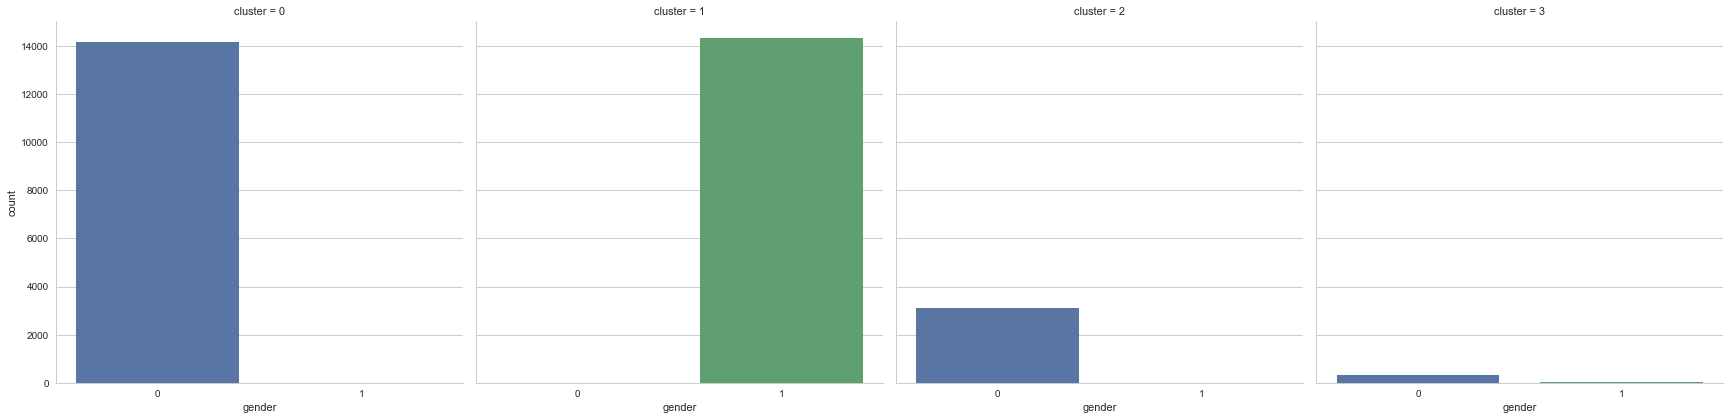

In [103]:
sns.factorplot(x='gender', col='cluster', kind="count", data=results_clus, size=6)
#sns.set(style="whitegrid")

In [95]:
cluster0['gender'].value_counts()

0    14176
Name: gender, dtype: int64

In [104]:
cluster1['gender'].value_counts()

1    14325
Name: gender, dtype: int64

In [105]:
cluster2['gender'].value_counts()

0    3113
Name: gender, dtype: int64

In [106]:
cluster3['gender'].value_counts()

0    328
1     42
Name: gender, dtype: int64

Interestingly cluster0 and cluster2 are comprised only of men and cluster1 is comprised only of women. cluster3 is mostly comprised of men (89%).    

**Age**

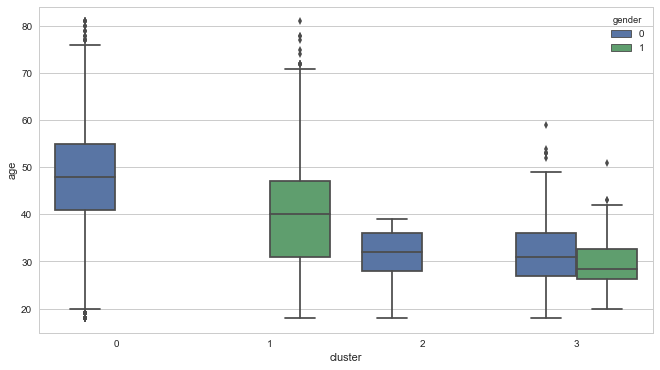

In [115]:
plt.figure(figsize=(11,6))
sns.boxplot(x="cluster", y="age", data=results_clus, hue='gender')
plt.show()

The minimum age for all clusters is 18 and the maximum for clusters0, to cluster3 is 81, 81, 39, and 59 respectively. 

**Halfway through**

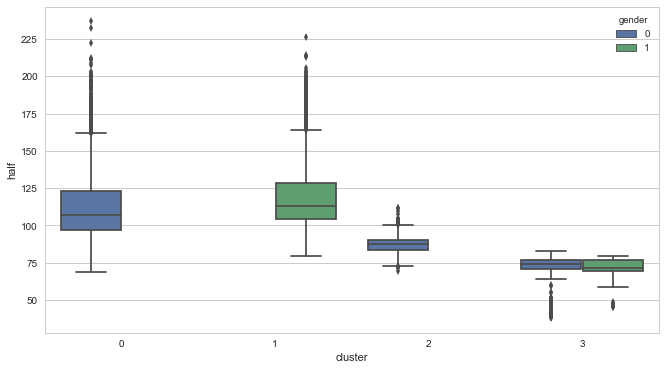

In [118]:
plt.figure(figsize=(11,6))
sns.boxplot(x="cluster", y="half", data=results_clus, hue='gender')
plt.show()

At the hafway line many athelets in every cluster are closer together than the finish line.  

**Overall time**

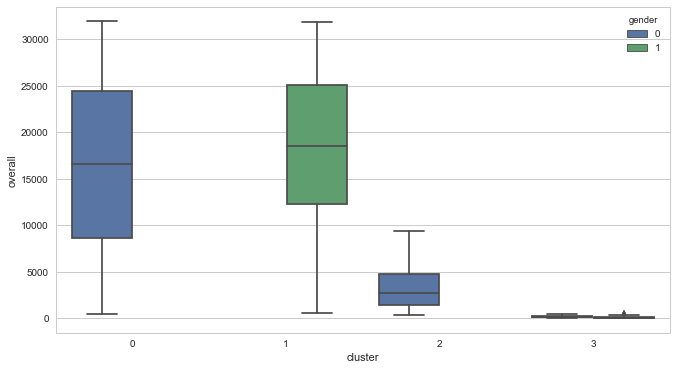

In [117]:
plt.figure(figsize=(11,6))
sns.boxplot(x="cluster", y="overall", data=results_clus, hue='gender')
plt.show()

The first two clusters have athelets with long minutes than the last two.

Overall the K-means algorithm has grouped athelets in clusters which are clearly different from each other.  